In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [37]:
import keras,tensorflow
keras.__version__
tensorflow.__version__
shap.__version__

'2.2.2'

'1.10.0'

'0.28.3'

In [2]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
dataset = pd.read_csv('./data/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset = dataset.dropna(axis=0).iloc[:,:-1]
dataset.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200
2006-01-04,82.20,82.50,81.33,81.95,9840600
2006-01-05,81.40,82.90,81.00,82.50,7213500
2006-01-06,83.95,85.03,83.41,84.95,8197400
2006-01-09,84.10,84.25,83.38,83.73,6858200


In [5]:
training_set = dataset[:'2016'].iloc[:,:-1].values
test_set = dataset['2017':].iloc[:,:-1].values

sc = MinMaxScaler(feature_range=(0,1))
training_set = sc.fit_transform(training_set)
test_set = sc.fit_transform(test_set)


training_set.shape
test_set.shape

(2769, 4)

(250, 4)

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set[i-60:i,:])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape
y_train.shape

(2709, 60, 4)

(2709,)

In [104]:
# Reshaping X_train for efficient modelling
# X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [9]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],4)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
2709/2709 [==============================] - 21s 8ms/step - loss: 0.0205
Epoch 2/5
2709/2709 [==============================] - 15s 6ms/step - loss: 0.0100
Epoch 3/5
2709/2709 [==============================] - 15s 6ms/step - loss: 0.0079: 2s -
Epoch 4/5
2709/2709 [==============================] - 15s 6ms/step - loss: 0.0070
Epoch 5/5
2709/2709 [==============================] - 17s 6ms/step - loss: 0.0063


In [11]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset[:'2016'].iloc[:,:-1],dataset['2017':].iloc[:,:-1]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs.shape
#inputs = inputs.reshape(-1,1)
#inputs.shape
inputs  = sc.fit_transform(inputs)

(310, 4)

In [12]:
inputs.shape

(310, 4)

In [21]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,:])
X_test = np.array(X_test)
X_train.shape
X_test.shape
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],4))
predicted_stock_price = regressor.predict(X_test)
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

(2709, 60, 4)

(251, 60, 4)

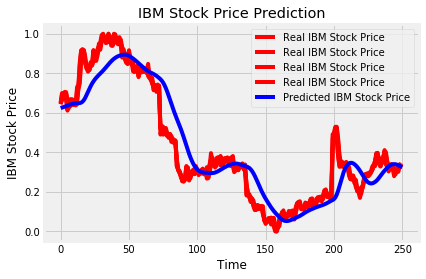

In [22]:
plot_predictions(test_set,predicted_stock_price)


# SHAP

In [27]:
import shap

In [24]:
X_train.shape
X_test.shape

(2709, 60, 4)

(251, 60, 4)

In [28]:
explainer = shap.DeepExplainer(regressor, X_train[:50])

In [29]:
shap_values = explainer.shap_values(X_test[:5])

In [38]:
X_train.shape

(2709, 60, 4)

In [30]:
explainer.expected_value[0]

0.07005064

In [41]:
np.array(shap_values).shape

(1, 5, 60, 4)

In [31]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1], X_test[0])

In [32]:
shap.force_plot(explainer.expected_value[0], shap_values[0][2], X_test[0])

In [33]:
shap.force_plot(explainer.expected_value[0], shap_values[0][3], X_test[0])

In [91]:
 shap_values[0][1]

array([[ 1.03972502e-09],
       [ 7.34667956e-10],
       [ 4.56062648e-10],
       [ 2.06659585e-10],
       [-3.32057038e-11],
       [-3.13042573e-10],
       [-7.21803853e-10],
       [-1.29598771e-09],
       [-2.01633010e-09],
       [-2.86706103e-09],
       [-3.95642056e-09],
       [-4.85586641e-09],
       [-4.75477194e-09],
       [-2.10612076e-09],
       [ 3.72895541e-09],
       [ 1.28562983e-08],
       [ 2.56092878e-08],
       [ 4.28919895e-08],
       [ 6.61778282e-08],
       [ 9.97845978e-08],
       [ 1.42837155e-07],
       [ 2.13512055e-07],
       [ 3.02760000e-07],
       [ 4.45241689e-07],
       [ 7.31097630e-07],
       [ 1.03666356e-06],
       [ 1.37848867e-06],
       [ 1.63214264e-06],
       [ 1.86457337e-06],
       [ 1.99263444e-06],
       [ 2.19235511e-06],
       [ 2.99771425e-06],
       [ 5.13316146e-06],
       [ 8.92575201e-06],
       [ 1.34888681e-05],
       [ 1.62400543e-05],
       [ 1.40104500e-05],
       [ 7.25258983e-06],
       [ 4.5